In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
pd.set_option('precision', 4)
plt.rcParams.update({'font.size': 15})

In [118]:
dataset = 'lastfm'
slugs_df = pd.read_csv('slugs.csv', sep=';').set_index('Metrics')
folder='/home/arthur/Documents/Doutorado/exp/recommendation/ludewig/results/ir/test_online/%s/' % dataset
#files= ['test_window_TEST_knn_%s.%s.csv', 'test_window_next_knn2_%s.%s.csv', 'test_window_next_rules_%s.%s.csv', 'test_window_next_neural_%s.%s.csv']
#files= ['dyn_online_knn.1.csv']
#files= ['dyn_online_rules.1.csv', 'dyn_online_knn.1.csv', 'dyn_online_knn2.2.csv']
files= ['dyn_online_rules.1.csv', 'dyn_online_knn.1.csv']
#files= ['dynamic.1.csv']
#files= ['dyn_TEST_online.1.csv', 'dyn_online_knn.1.csv']
num_slices = 1
dfx = None
df = None
for j, file in enumerate(files):
    #for slice_num in range(num_slices):
    filename = os.path.join(folder, file)
    if j == 0:
        df = pd.read_csv(filename, sep='\t')
    else:
        dfx = pd.read_csv(filename, sep='\t')[:]
        df = df.append(dfx)
#metr = df.Metrics.values
#df = df.groupby(['Metrics']).mean()
#df = df.reset_index()
df.set_index('key', inplace=True)

df.insert(0, 'key', slugs_df['slug'])
df = df[df.key != 'skip']
df.reset_index(drop=True, inplace=True)
df.matches /= df.num_items
xdf = df.groupby('key').sum()[['fit_time', 'predict_time', 'reward_norm', 'matches']].astype(int).sort_values('reward_norm', ascending=False)
xdf.style.background_gradient(axis = 0, cmap='Blues')
#df

,fit_time,predict_time,reward_norm,matches
key,,,,
IR-MC,38,705,7392,7411
IR-1NN,26,736,4932,4513
MC,10,905,4583,7196
SR,9,2238,4546,7173
IR-TFIDF,29,3874,2777,5301
AR,13,5404,2499,5256
VSKNN,11,12857,2094,6517
STAN,12,14650,1863,5972
SKNN,8,5870,1743,6472


In [94]:
fig_path = '/home/arthur/Documents/Doutorado/papers/rec/umuai'

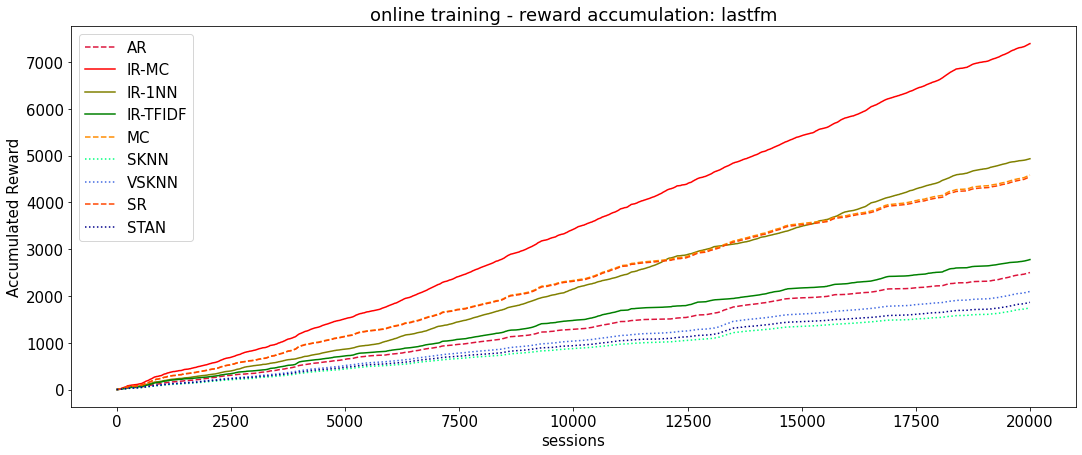

In [95]:
#algs = list(df['key'].unique())
plt.figure(figsize=(18, 7))
refs = slugs_df.set_index('slug')
lines = {'neural': '--', 'IR': '-', 'kNN': ':', 'rules': '--'}
algs = refs[refs.index != 'skip']

for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    dfx['acc_reward'] = dfx.reward_norm.cumsum()    
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    plt.plot(dfx['Unnamed: 0'], dfx.acc_reward, 
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)
plt.legend() # bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)
#plt.xticks(range(20), range(1, 21))
plt.xlabel('sessions')
plt.ylabel('Accumulated Reward')
plt.title("online training - reward accumulation: %s" % dataset)
plt.savefig(os.path.join(fig_path, '%s_acc_reward.pdf' % dataset), format='pdf')
plt.show()

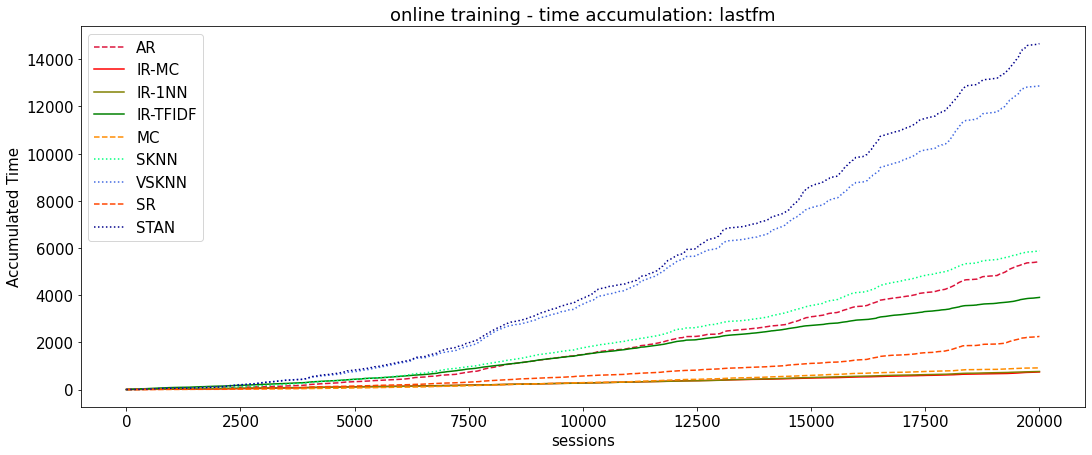

In [96]:
#algs = list(df['key'].unique())
plt.figure(figsize=(18, 7))
refs = slugs_df.set_index('slug')
lines = {'neural': '--', 'IR': '-', 'kNN': ':', 'rules': '--'}
algs = refs[refs.index != 'skip']

for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    dfx['total_time'] = dfx['predict_time'] + dfx['fit_time']
    dfx['acc_time'] = dfx.total_time.cumsum() 
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    plt.plot(dfx['Unnamed: 0'], dfx.acc_time,
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)             
plt.legend() #bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)
#plt.xticks(range(20), range(1, 21))
plt.xlabel('sessions')
plt.ylabel('Accumulated Time')
plt.title("online training - time accumulation: %s" % dataset)
plt.savefig(os.path.join(fig_path, '%s_acc_time.pdf' % dataset), format='pdf')
plt.show()

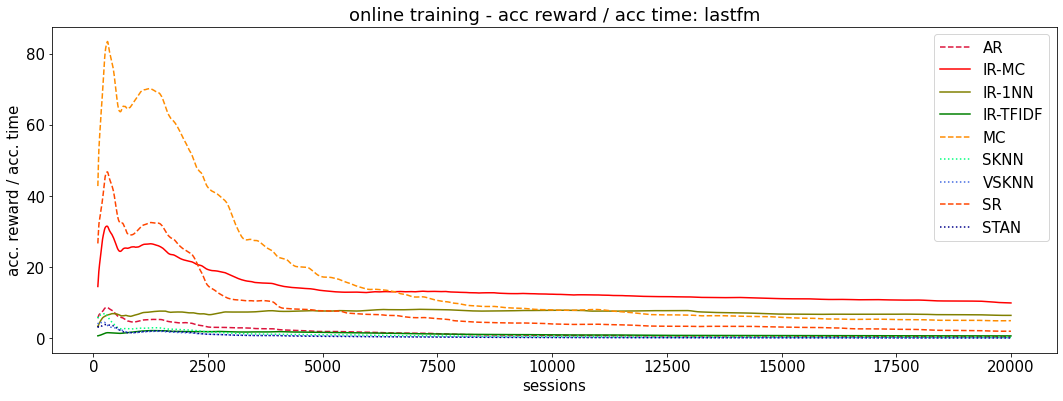

In [97]:
algs = list(df['key'].unique())
plt.figure(figsize=(18, 6))
refs = slugs_df.set_index('slug')
lines = {'neural': '--', 'IR': '-', 'kNN': ':', 'rules': '--'}
algs = refs[refs.index != 'skip']


for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    dfx['acc_reward'] = dfx.reward_norm.cumsum()    
    dfx['total_time'] = dfx['predict_time'] + dfx['fit_time']
    dfx['acc_time'] = dfx.total_time.cumsum()
    dfx['reward_time'] = dfx.acc_reward / dfx.acc_time
    fl = dfx['reward_time']
    fl = fl.rolling(100, win_type=None).mean()
    
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    
    plt.plot(dfx['Unnamed: 0'], fl,
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)                  
plt.legend() # bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)
#plt.xticks(range(20), range(1, 21))
plt.xlabel('sessions')
#plt.log_y(True)
plt.ylabel('acc. reward / acc. time')
plt.title("online training - acc reward / acc time: %s" % dataset)
plt.savefig(os.path.join(fig_path, '%s_acc_reward_time.pdf' % dataset), format='pdf')
plt.show()

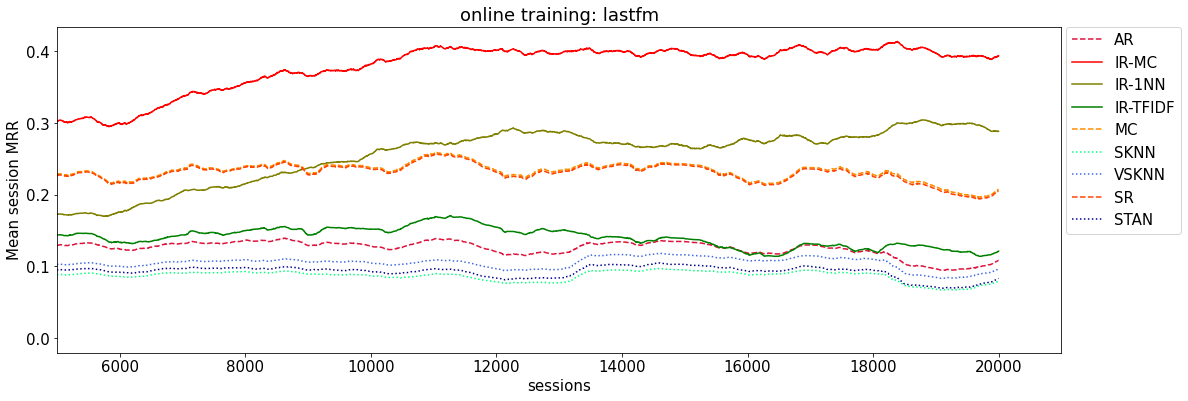

In [98]:
#algs = list(df['key'].unique())
plt.figure(figsize=(18, 6))
win_size = 5000

refs = slugs_df.set_index('slug')
lines = {'neural': '--', 'IR': '-', 'kNN': ':', 'rules': '--'}
algs = refs[refs.index != 'skip']

for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    fl = dfx.reward_norm.rolling(win_size, win_type=None).mean().fillna(0)
    
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    
    plt.plot(range(len(fl)), fl,
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)                 
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('sessions')
plt.xlim(win_size)
plt.ylabel('Mean session MRR')
plt.title("online training: %s" % dataset)
plt.savefig(os.path.join(fig_path, '%s_mean_mrr.pdf' % dataset), format='pdf')
plt.show()

In [99]:
xdf

,fit_time,predict_time,reward_norm,matches
key,,,,
IR-MC,38,705,7392,79457
IR-1NN,26,736,4932,47904
MC,10,905,4583,77094
SR,9,2238,4546,76839
IR-TFIDF,29,3874,2777,57328
AR,13,5404,2499,56699
VSKNN,11,12857,2094,70070
STAN,12,14650,1863,63352
SKNN,8,5870,1743,68607


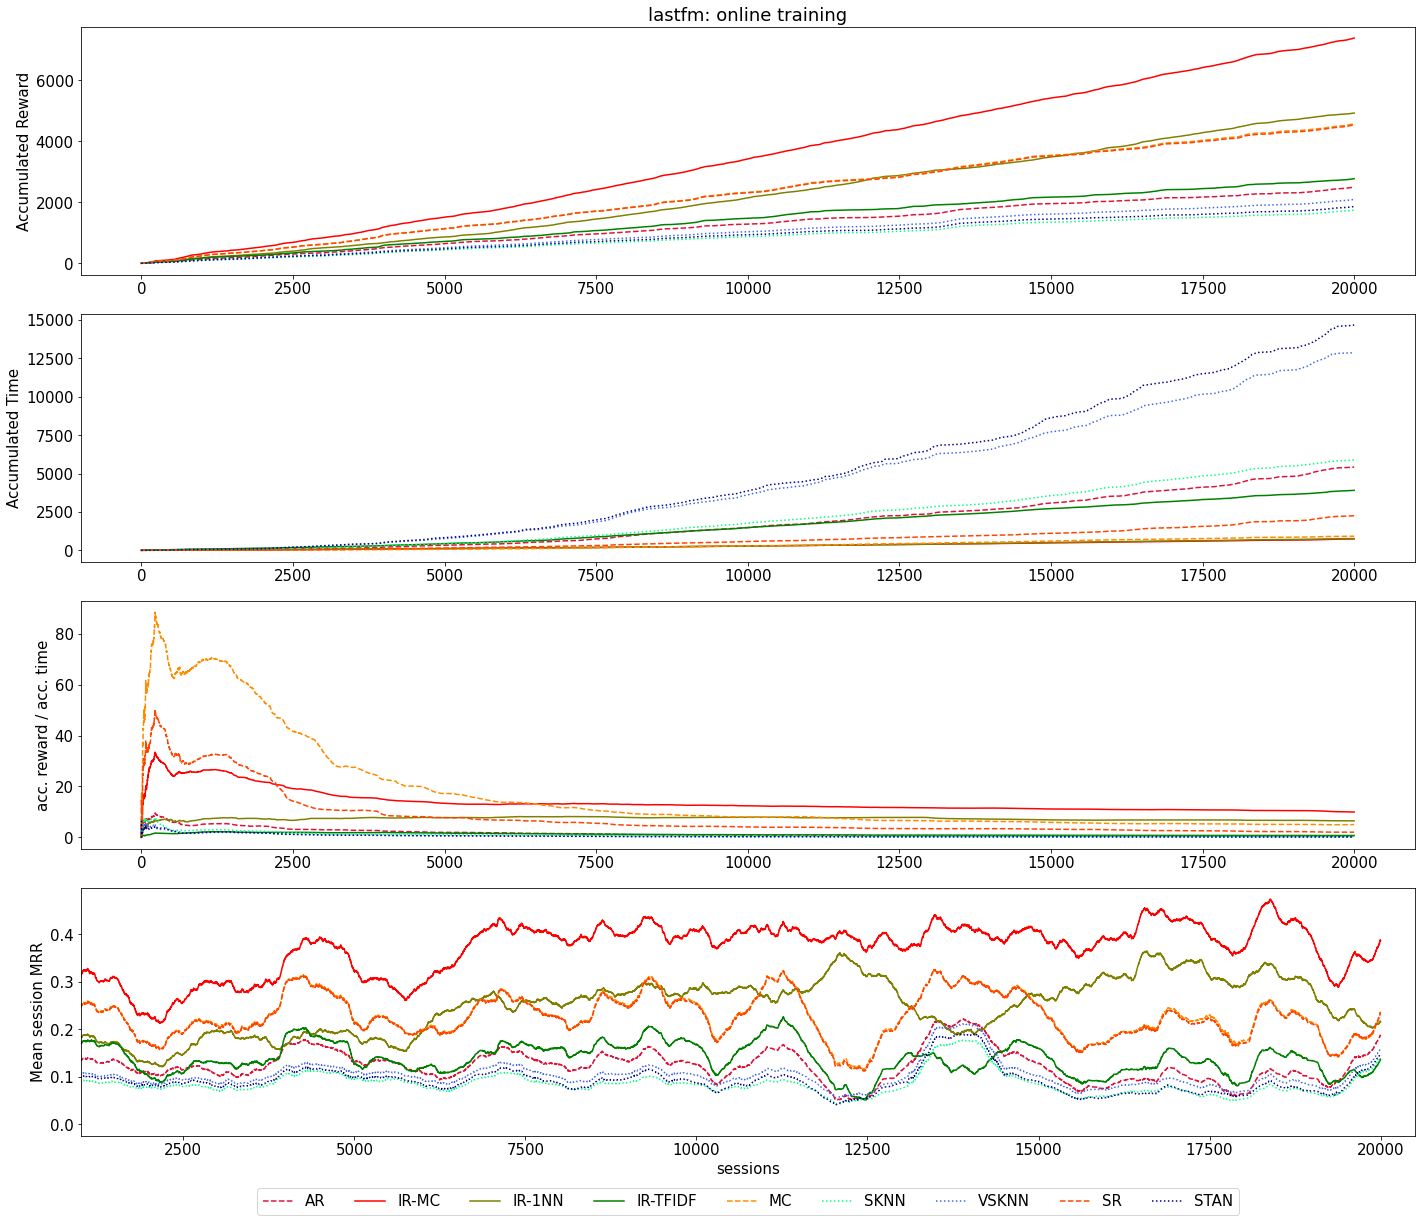

In [100]:
#algs = list(df['key'].unique())

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False, figsize=(20, 17))
win_size = 1000
refs = slugs_df.set_index('slug')
lines = {'neural': '--', 'IR': '-', 'kNN': ':', 'rules': '--'}
algs = refs[refs.index != 'skip']

for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    dfx['acc_reward'] = dfx.reward_norm.cumsum()    
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    ax1.plot(dfx['Unnamed: 0'], dfx.acc_reward, 
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)

for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    dfx['total_time'] = dfx['predict_time'] + dfx['fit_time']
    dfx['acc_time'] = dfx.total_time.cumsum() 
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    ax2.plot(dfx['Unnamed: 0'], dfx.acc_time,
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)    
    
for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    dfx['acc_reward'] = dfx.reward_norm.cumsum()    
    dfx['total_time'] = dfx['predict_time'] + dfx['fit_time']
    dfx['acc_time'] = dfx.total_time.cumsum()
    dfx['reward_time'] = dfx.acc_reward / dfx.acc_time
    fl = dfx['reward_time']
    #fl = fl.rolling(win_size, win_type=None).mean()
    
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    
    ax3.plot(dfx['Unnamed: 0'], fl,
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)   
    
for col in algs.index:
    if col=='GRU4Rec':
        continue
    dfx = df[df.key==col].sort_values('Unnamed: 0')
    fl = dfx.reward_norm.rolling(win_size, win_type=None).mean().fillna(0)
    
    ref = refs.loc[col]
    color = ref.color if ref.color != 'skip' else None
    
    ax4.plot(range(len(fl)), fl,
             color=color, 
             linestyle=lines[refs.loc[col].alg_type],             
             label=col)    
ax4.set_xlim((win_size,20500))
#ax3.set_xlim((win_size,20500))

#ax1.legend()
ax1.set_ylabel('Accumulated Reward')
#ax1.set_title("online training - reward accumulation: %s" % dataset)   

ax2.set_ylabel('Accumulated Time')
#ax2.set_title("online training - time accumulation: %s" % dataset)

ax3.set_ylabel('acc. reward / acc. time')
#ax3.set_title("online training - reward accumulation: %s" % dataset) 

ax4.set_ylabel('Mean session MRR')
#ax4.set_title("online training - reward accumulation: %s" % dataset) 
#plt.legend() # bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)
#plt.xticks(range(20), range(1, 21))
plt.xlabel('sessions')
ax4.legend(bbox_to_anchor=(0.5, -.35), loc='lower center', ncol=10)
#plt.ylabel('Accumulated Reward')
ax1.set_title("%s: online training" % dataset)
#plt.savefig(os.path.join(fig_path, '%s_acc_reward.pdf' % dataset), format='pdf')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, '%s_dyn_all.pdf' % dataset), format='pdf')

plt.show()

In [101]:
txt = xdf.reset_index(drop=False).to_latex(col_space=1, index=False)
open('/home/arthur/Documents/Doutorado/papers/rec/umuai/tbl_dyn_%s.tex' % dataset, 'w').write(txt)
#xdf.set_index('metrics')

740